# **Carregando a base de dados e as bibliotecas necessárias**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
from scipy import stats
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
from sklearn.datasets import make_classification

In [ ]:
# Modificando o nome das colunas e atribuindo os valores vazios de "-" dentro da base de dados
colnames = ['Sex', 'Lenght', 'Diameter', 'Height', 'WholeWeight', 'ShuckeDWeight', 'VisceraWeight', 'ShellWeight', 'Rings']
base = pd.read_csv('abalone-dataPI.csv', header= None, names = colnames, na_values=["-"])
base

,Sex,Lenght,Diameter,Height,WholeWeight,ShuckeDWeight,VisceraWeight,ShellWeight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15.0
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7.0
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9.0
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10.0
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7.0
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11.0
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10.0
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9.0
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10.0


# **Percepção de dados vazios dentro da base de dados**

In [ ]:
# Verificando os valores faltantes dentro das colunas atribuidas
base.info()
base.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Sex            4136 non-null   object 
 1   Lenght         4167 non-null   float64
 2   Diameter       4167 non-null   float64
 3   Height         4167 non-null   float64
 4   WholeWeight    4167 non-null   float64
 5   ShuckeDWeight  4144 non-null   float64
 6   VisceraWeight  4167 non-null   float64
 7   ShellWeight    4161 non-null   float64
 8   Rings          4167 non-null   float64
dtypes: float64(8), object(1)
memory usage: 293.8+ KB


Sex              41
Lenght           10
Diameter         10
Height           10
WholeWeight      10
ShuckeDWeight    33
VisceraWeight    10
ShellWeight      16
Rings            10
dtype: int64

# **início do tratamento da tabela**

## **Tratamento de anomalias de dados**

**Notando que há uma quantidade exarcerbada de outliers dentro da base de dados (6,8% das amostras, considerando o método de Tukey), efetuamos uma separação de tais outliers em um novo frame. Desse novo frame, analisamos os padrões para encontrar dois tipos de dados (anomalias e erros de inputação) e, subsequentemente, apagar os dados mau inputados. Resumidamente, estamos 'criando' um novo grupo amostral a partir dos outliers da base Abalone e, em sequência, definiremos quais são os 'outliers dos outliers' como viés para a retirada de tais dados mau inputados, de maneira automática e mais precisa.**


In [ ]:
# Criação de algoritmos para separação dos outliers (Método de Tukey)
def QuartileCatch(x, percent, data):
    x =  data.quantile(q= percent, numeric_only=True)
    return x

def Tukey(data):
    Q3 = QuartileCatch("Quartile3", 0.75, data)
    Q1 = QuartileCatch("Quartile1", 0.25, data)
    AIQ = Q3 - Q1
    Max = Q3 + (AIQ*1.5)
    Min = Q1 - (AIQ*1.5)
    return [Min, Max]

def OnlyOutliers(data):
    frame = pd.DataFrame()
    index = 0 #turns on 'data' columns(all)
    n = 0 #turns on 'Tukey' indexes(numeric_only)
    for i in data:
        if isinstance(data.iloc[1,index],float):
            only_outlier = data[(data[i] < Tukey(data)[0][n]) | (data[i] > Tukey(data)[1][n])]
            new_frame = pd.concat([frame, only_outlier], axis=1)
            n += 1
        else: n += 0
        index += 1
    return new_frame

def WithoutOutliers(data):
    index = 0
    n = 0
    for i in data:
        if isinstance(data.iloc[1,index],float):
            new_frame = data.drop(data[(data[i] < Tukey(data)[0][n]) | (data[i] > Tukey(data)[1][n])].index)
            n += 1
        else: n += 0
        index += 1
    return new_frame

In [ ]:
# Algoritmo para retirar os dados mau imputados
def BadInputs(data):
    index = 0 #turns on data columns(all)
    n = 0 #turns on Tukey values(numeric_only)
    for i in data:
        if isinstance(data.iloc[1,index],float):
            data.loc[data[i] < Tukey(data)[0][n], i] = np.nan
            data.loc[data[i] > Tukey(data)[1][n], i] = np.nan
            n += 1
        else: n += 0
        index += 1
    return data

#Frame de dados dos outliers (com dados mau inputados já apagados)
baseOutliers = BadInputs(OnlyOutliers(base))

In [ ]:
#População amostral SEM os outliers (apenas dados dentro da média comum, segundo o método)
base_withoutOutliers = WithoutOutliers(base)

#População amostral COM os outliers tratados (sendo que dados mau imputados foram substituídos por NaN)
#ATENÇÃO: Observe que, foram substituídos APENAS os dados incorretos, e não a amostra inteira...
base_withOutliers = pd.concat([base_withoutOutliers, baseOutliers])

 **Com esta nova divisão feita será possível tratar, mais abaixo, de duas variáveis distintas para medir o comportamento entre a inputação em populações COM outliers (withOutliers) e SEM outliers(withoutOutliers). Será também inputado dados na base DE outliers, separadamente, que será incluída então na variável "without_Outliers" para a conclusão final. O objetivo é determinar, com maior aptidão, qual será a melhor maneira de tratar a base Abalone original e implementar o algoritmo de imputação, de forma que as chances de corrupção dos dados sejam minimizadas e erros significativos na imputação dos dados faltantes sejam evitados.**


**Explicaremos mais a frente como será definido um "vencedor" para este teste de hipótese populacional/amostral, ou mesmo se haverá um, em caso de pouca disruptura entre ambos os cenários de treinamento.**


## **Tratamento de dados faltantes**




**A partir do tratamento e limpeza executada anteriormente, passaremos agora pela fase final do trabalho (inputação de valores faltantes), sendo que faremos a aplicação metodológica do algoritmo KNN, para a inputação dos valores numéricos faltantes. Para os dados categóricos da coluna 'Sex', utilizamos algumas regras de quartis 'manualmente' para inputar valores faltantes, em base do pertencimento dos dados numéricos em relação a seus semelhantes.**

**Repare ainda que, logo no início do trabalho criamos todas as funções necessárias para essa fase do processo, a qual o leitor poderá utilizar como apêndice, caso deseje compreender melhor o comportamento dos trechos de código utilizados.**


**Como citado anteriormente, utilizaremo-nos de 2 variáveis separadas para a execução do trabalho, já que nosso objetivo é justamente encontrar a metodologia que melhor se aplique a base original. Nesse sentido, referimo-nos a aplicação na qual a base sofra a menor disruptura possível em comparativo à distribuição original. Esse viés será avaliado através de gráficos de distribuição de frequência, que irão (ou não) apontar qual variável melhor se encaixará.**


#### **Recortes para utilização dentro da imputação dos valores**

In [ ]:
# Separando as colunas dentro da base de dados
base_withoutOutliersSex = base_withoutOutliers["Sex"]
base_withoutOutliersNoSex = base_withoutOutliers.drop("Sex", axis= 1)
baseOutliersSex = baseOutliers["Sex"]
baseOutliersNoSex = baseOutliers.drop("Sex", axis = 1)
base_withOutliersSex = base_withOutliers["Sex"]
base_withOutliersNoSex = base_withOutliers.drop("Sex", axis = 1)

In [ ]:
# Ajeitando os index das colunas sex
base_withOutliersSex = base_withOutliersSex.reset_index(drop=True)
baseOutliersSex = baseOutliersSex.reset_index(drop=True)
base_withoutOutliersSex = base_withoutOutliersSex.reset_index(drop=True)

**Para utilização do KNN, é indispensável a definição da quantidade de vizinhos que serão dispostos dentro da classificação do DataFrame. Pensando nisso e, indo um pouco além, treinaremos um teste de acurácia entre os valores do Cluster 'k' entre 1 e 7, para então definir o maior valor possível no prosseguimento da utilização do algoritmo em si.**

In [ ]:
# Fazer o teste dos clusters por acuracia
# Gerar dados de exemplo
X = base_withoutOutliersNoSex.dropna()
y = base_withoutOutliersNoSex.Rings.dropna()[0:3820]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
accuracies = []
for k in range(1, 7):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, y_train)
  y_pred = knn.predict(X_test)
  # Calculo das acuracias
  accuracy = accuracy_score(y_test, y_pred)
  accuracies.append(accuracy)
best_k = accuracies.index(max(accuracies)) + 1
for k, accuracy in enumerate(accuracies, 1):
    print(f"Acurácia para K={k}: {accuracy}")
print(f"\nMelhor valor de K: {best_k}")


Acurácia para K=1: 0.1505235602094241
Acurácia para K=2: 0.13743455497382198
Acurácia para K=3: 0.1256544502617801
Acurácia para K=4: 0.13481675392670156
Acurácia para K=5: 0.1544502617801047
Acurácia para K=6: 0.1518324607329843

Melhor valor de K: 5


In [ ]:
imputer = KNNImputer(n_neighbors=best_k)

#### **Substituição dos valores faltantes das demais colunas**

In [ ]:
# Imputando os dados faltantes nas colunas numericas da base com outliers
base_withOutliersNoSexInputed = pd.DataFrame(imputer.fit_transform(base_withOutliersNoSex), columns= base_withOutliersNoSex.columns)
base_withOutliersNoSexInputed

,Lenght,Diameter,Height,WholeWeight,ShuckeDWeight,VisceraWeight,ShellWeight,Rings
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15.0
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7.0
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9.0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10.0
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7.0
...,...,...,...,...,...,...,...,...
4172,0.670,0.535,0.185,1.5970,0.6275,0.3500,0.4700,21.0
4173,0.550,0.440,0.165,0.8605,0.3120,0.1690,0.3000,17.0
4174,0.550,0.440,0.160,0.9910,0.3480,0.1680,0.3750,20.0
4175,0.475,0.365,0.140,0.6175,0.2020,0.1445,0.1900,16.0


In [ ]:
base_withOutliersNoSexInputed.info()
base_withOutliersNoSexInputed.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Lenght         4177 non-null   float64
 1   Diameter       4177 non-null   float64
 2   Height         4177 non-null   float64
 3   WholeWeight    4177 non-null   float64
 4   ShuckeDWeight  4177 non-null   float64
 5   VisceraWeight  4177 non-null   float64
 6   ShellWeight    4177 non-null   float64
 7   Rings          4177 non-null   float64
dtypes: float64(8)
memory usage: 261.2 KB


Lenght           0
Diameter         0
Height           0
WholeWeight      0
ShuckeDWeight    0
VisceraWeight    0
ShellWeight      0
Rings            0
dtype: int64

In [ ]:
# Imputando os dados faltantes nas colunas numericas
base_withoutOutliersNoSexInputed = pd.DataFrame(imputer.fit_transform(base_withoutOutliersNoSex), columns= base_withoutOutliersNoSex.columns)
base_withoutOutliersNoSexInputed

,Lenght,Diameter,Height,WholeWeight,ShuckeDWeight,VisceraWeight,ShellWeight,Rings
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15.0
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7.0
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9.0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10.0
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7.0
...,...,...,...,...,...,...,...,...
3885,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11.0
3886,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10.0
3887,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9.0
3888,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10.0


In [ ]:
base_withoutOutliersNoSexInputed.info()
base_withoutOutliersNoSexInputed.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3890 entries, 0 to 3889
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Lenght         3890 non-null   float64
 1   Diameter       3890 non-null   float64
 2   Height         3890 non-null   float64
 3   WholeWeight    3890 non-null   float64
 4   ShuckeDWeight  3890 non-null   float64
 5   VisceraWeight  3890 non-null   float64
 6   ShellWeight    3890 non-null   float64
 7   Rings          3890 non-null   float64
dtypes: float64(8)
memory usage: 243.2 KB


Lenght           0
Diameter         0
Height           0
WholeWeight      0
ShuckeDWeight    0
VisceraWeight    0
ShellWeight      0
Rings            0
dtype: int64

In [ ]:
# Imputando os dados faltantes na base dos outliers
baseOutliersNoSexInputed = pd.DataFrame(imputer.fit_transform(baseOutliersNoSex), columns= baseOutliersNoSex.columns)
baseOutliersNoSexInputed

,Lenght,Diameter,Height,WholeWeight,ShuckeDWeight,VisceraWeight,ShellWeight,Rings
0,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.3300,20.0
1,0.545,0.425,0.125,0.7680,0.2940,0.1495,0.2600,16.0
2,0.550,0.440,0.150,0.8945,0.3145,0.1510,0.3200,19.0
3,0.665,0.525,0.165,1.3380,0.5515,0.3575,0.3500,18.0
4,0.680,0.550,0.175,1.7980,0.8150,0.3925,0.4550,19.0
...,...,...,...,...,...,...,...,...
282,0.670,0.535,0.185,1.5970,0.6275,0.3500,0.4700,21.0
283,0.550,0.440,0.165,0.8605,0.3120,0.1690,0.3000,17.0
284,0.550,0.440,0.160,0.9910,0.3480,0.1680,0.3750,20.0
285,0.475,0.365,0.140,0.6175,0.2020,0.1445,0.1900,16.0


In [ ]:
baseOutliersNoSexInputed.info()
baseOutliersNoSexInputed.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Lenght         287 non-null    float64
 1   Diameter       287 non-null    float64
 2   Height         287 non-null    float64
 3   WholeWeight    287 non-null    float64
 4   ShuckeDWeight  287 non-null    float64
 5   VisceraWeight  287 non-null    float64
 6   ShellWeight    287 non-null    float64
 7   Rings          287 non-null    float64
dtypes: float64(8)
memory usage: 18.1 KB


Lenght           0
Diameter         0
Height           0
WholeWeight      0
ShuckeDWeight    0
VisceraWeight    0
ShellWeight      0
Rings            0
dtype: int64

#### **Substituição dos valores faltantes de sex**

In [ ]:
# juntando as variaveis ao sex depois de inputatadas as numericas
base_withOutliersComplete = pd.concat([base_withOutliersSex, base_withOutliersNoSexInputed], axis=1)
base_withoutOutliersComplete = pd.concat([base_withoutOutliersSex, base_withoutOutliersNoSexInputed], axis=1)
baseOutliersComplete = pd.concat([baseOutliersSex, baseOutliersNoSexInputed], axis=1)
base_NoNa_Complete = pd.concat([base_withoutOutliersComplete, baseOutliersComplete], ignore_index=True)

In [ ]:
# Patches of sex
base_NoNa_CompleteSexF = base_NoNa_Complete[base_NoNa_Complete.Sex == "F"]
base_withOutliersCompleteSexF = base_withOutliersComplete[base_withOutliersComplete.Sex == "F"]
base_NoNa_CompleteSexM = base_NoNa_Complete[base_NoNa_Complete.Sex == "M"]
base_withOutliersCompleteSexM = base_withOutliersComplete[base_withOutliersComplete.Sex == "M"]
base_NoNa_CompleteSexI = base_NoNa_Complete[base_NoNa_Complete.Sex == "I"]
base_withOutliersCompleteSexI = base_withOutliersComplete[base_withOutliersComplete.Sex == "I"]

In [ ]:
columns = ['Lenght', 'Diameter', 'Height', 'WholeWeight', 'ShuckeDWeight', 'VisceraWeight', 'ShellWeight']

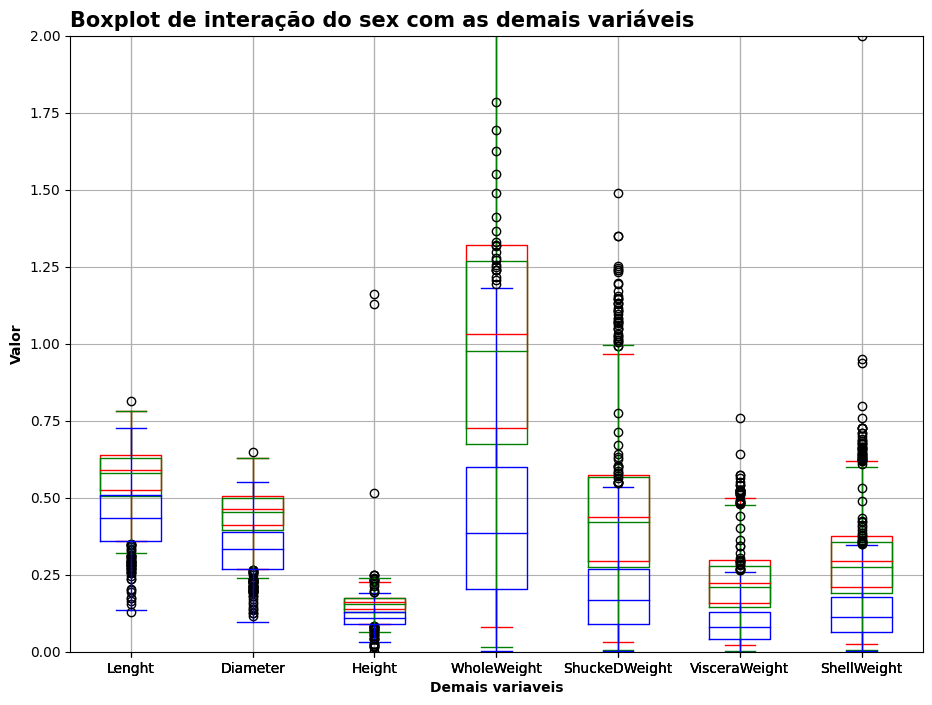

In [ ]:
# Visualização dos números e relações entre os valores de Sex e os demais grafico 1
plt.figure(figsize=(11,8))
base_NoNa_CompleteSexF.boxplot(column=columns, color=dict(boxes='r', whiskers='r', medians='r', caps='r'))
plt.ylim([0, 2])
base_NoNa_CompleteSexM.boxplot(column=columns, color=dict(boxes='g', whiskers='g', medians='g', caps='g'))
plt.ylim([0, 2])
base_NoNa_CompleteSexI.boxplot(column=columns, color=dict(boxes='b', whiskers='b', medians='b', caps='b'))
plt.ylim([0, 2])
plt.title("Boxplot de interação do sex com as demais variáveis", fontsize=15, fontweight= "bold", loc="left")
plt.xlabel("Demais variaveis",fontweight= "bold")
plt.ylabel("Valor",fontweight= "bold")
plt.show()

**A partir da análise dos Boxplots apresentados acima, verificamos que não é possível determinar com precisão se um Abalone é feminino ou masculino, no entanto, é possível identificar quando ele se encontra dentro de um padrão infantil. Por conseguinte, decidimos focalizar nossa técnica de substituição apenas nesse padrão de agrupamento.**


**Para definir o limite da classe Infantil, foram feitas correlações dos boxplots com todas as variáveis e, foram selecionadas as que continham a menor quantidade de valores dentro dos dados infantis. Sendo assim, os dados faltantes infantis que haviam dentro da coluna "Sex" foram imputados com esse limite definido usando o corte das variáveis "F" e "M" (nos dados infantis).**

**Já com base as categorias "M" e "F", é notável nessa análise que as distribuições são muito próximas, o que torna inviável a determinação de um limite de separação claro entre elas. Portanto, optamos por descartar o restante dos dados mal imputados, pois tem proporção pequena em comparação a base inteira e não terão grande influência.**


In [ ]:
# Numeros da variavel "VisceraWeight"
print(base_NoNa_CompleteSexF.VisceraWeight.describe().round(4))
print(base_NoNa_CompleteSexM.VisceraWeight.describe().round(4))
print(base_NoNa_CompleteSexI.VisceraWeight.describe().round(4))

count    1290.0000
mean        0.2349
std         0.1380
min         0.0210
25%         0.1590
50%         0.2240
75%         0.2970
max         2.5600
Name: VisceraWeight, dtype: float64
count    1516.0000
mean        0.2175
std         0.1190
min         0.0030
25%         0.1460
50%         0.2105
75%         0.2785
max         2.3800
Name: VisceraWeight, dtype: float64
count    1330.0000
mean        0.0953
std         0.1122
min         0.0005
25%         0.0425
50%         0.0800
75%         0.1295
max         2.8650
Name: VisceraWeight, dtype: float64


In [ ]:
# Numeros da variavel "VisceraWeight"
print(base_NoNa_CompleteSexF.WholeWeight.describe().round(4))
print(base_NoNa_CompleteSexM.WholeWeight.describe().round(4))
print(base_NoNa_CompleteSexI.WholeWeight.describe().round(4))

count    1290.0000
mean        1.0734
std         0.7984
min         0.0800
25%         0.7272
50%         1.0329
75%         1.3196
max        21.5050
Name: WholeWeight, dtype: float64
count    1516.0000
mean        1.0056
std         0.5851
min         0.0155
25%         0.6736
50%         0.9762
75%         1.2696
max        11.1350
Name: WholeWeight, dtype: float64
count    1330.0000
mean        0.4366
std         0.3230
min         0.0020
25%         0.2051
50%         0.3840
75%         0.6003
max         5.2100
Name: WholeWeight, dtype: float64


In [ ]:
# Estabelecer o valor limite de corte para o sex
valorViscera = base_NoNa_CompleteSexM.VisceraWeight.describe()[4]
valorWhole = base_NoNa_CompleteSexM.WholeWeight.describe()[4]

In [ ]:
# Funcao para substituir os valores faltantes de Sex em base_NoNa de acordo com os limites
for i in range(0, len(base_NoNa_Complete)):
  if base_NoNa_Complete.VisceraWeight[i] < valorViscera and base_NoNa_Complete.WholeWeight[i] < valorWhole:
    if base_NoNa_Complete.Sex[i] == None: base_NoNa_Complete.Sex[i] = "I"

In [ ]:
# Funcao para substituir os valores faltantes de Sex em base_withOutliers de acordo com os limites
for i in range(0, len(base_withOutliersComplete)):
  if base_withOutliersComplete.VisceraWeight[i] < valorViscera and base_withOutliers.WholeWeight[i] < valorWhole:
    if base_withOutliersComplete.Sex[i] == None: base_withOutliers.Sex[i] = "I"

In [ ]:
# Tabelas imputadas e concatenadas para feição dos gráficos de frequência.
# Base com outliers trátada de forma separada.
base_NoNa_Complete = base_NoNa_Complete.dropna()
# Base com outliers trátada de forma conjunta.
base_withOutliersComplete = base_withOutliersComplete.dropna()

In [ ]:
#Verificando os dados das variáveis da base após a nova alteração

In [ ]:
base_NoNa_Complete.info()
base_NoNa_Complete.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4136 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Sex            4136 non-null   object 
 1   Lenght         4136 non-null   float64
 2   Diameter       4136 non-null   float64
 3   Height         4136 non-null   float64
 4   WholeWeight    4136 non-null   float64
 5   ShuckeDWeight  4136 non-null   float64
 6   VisceraWeight  4136 non-null   float64
 7   ShellWeight    4136 non-null   float64
 8   Rings          4136 non-null   float64
dtypes: float64(8), object(1)
memory usage: 323.1+ KB


Sex              0
Lenght           0
Diameter         0
Height           0
WholeWeight      0
ShuckeDWeight    0
VisceraWeight    0
ShellWeight      0
Rings            0
dtype: int64

In [ ]:
base_withOutliersComplete.info()
base_withOutliersComplete.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4136 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Sex            4136 non-null   object 
 1   Lenght         4136 non-null   float64
 2   Diameter       4136 non-null   float64
 3   Height         4136 non-null   float64
 4   WholeWeight    4136 non-null   float64
 5   ShuckeDWeight  4136 non-null   float64
 6   VisceraWeight  4136 non-null   float64
 7   ShellWeight    4136 non-null   float64
 8   Rings          4136 non-null   float64
dtypes: float64(8), object(1)
memory usage: 323.1+ KB


Sex              0
Lenght           0
Diameter         0
Height           0
WholeWeight      0
ShuckeDWeight    0
VisceraWeight    0
ShellWeight      0
Rings            0
dtype: int64

### **Justificativa da imputação e tratamento dos dados**

**Abaixo, apresentamos os resultados dos dados tratados durante todo a jornada. Como dito, decidimos como sendo melhor apresentar tais variáveis dos DataFrames através de gráficos de dispersão:**

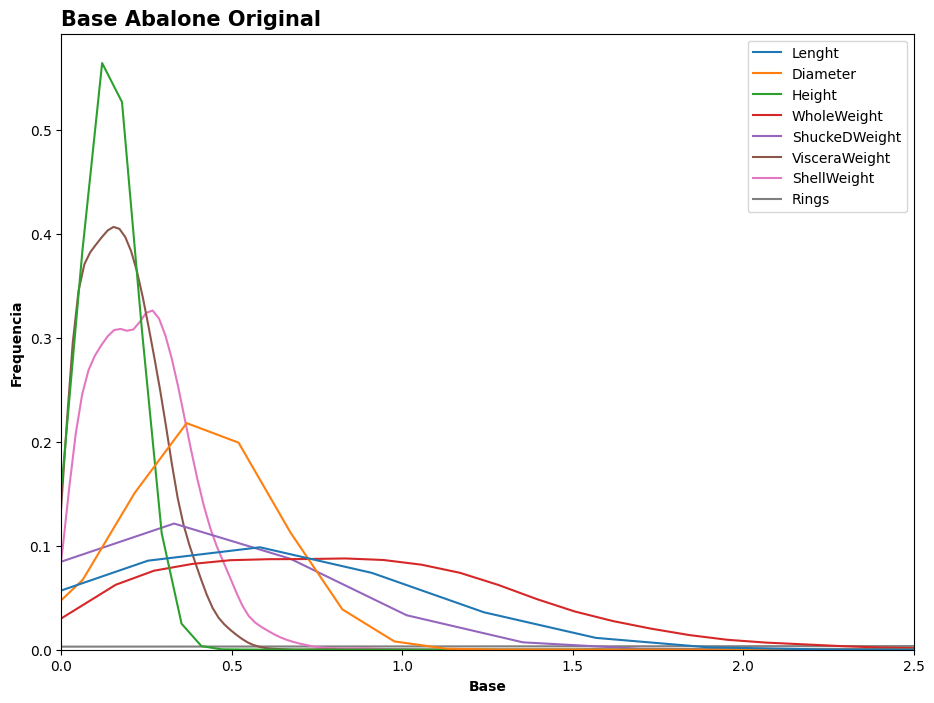

In [ ]:
# Grafico de frequencia da base sem modificação (base original, recebida para o trabalho)
plt.figure(figsize=(11,8))
sns.kdeplot(data=base)
plt.title("Base Abalone Original", fontsize=15, fontweight= "bold", loc="left")
plt.xlabel("Base",fontweight= "bold")
plt.ylabel("Frequencia",fontweight= "bold")
plt.xlim(0, 2.5)
plt.show()

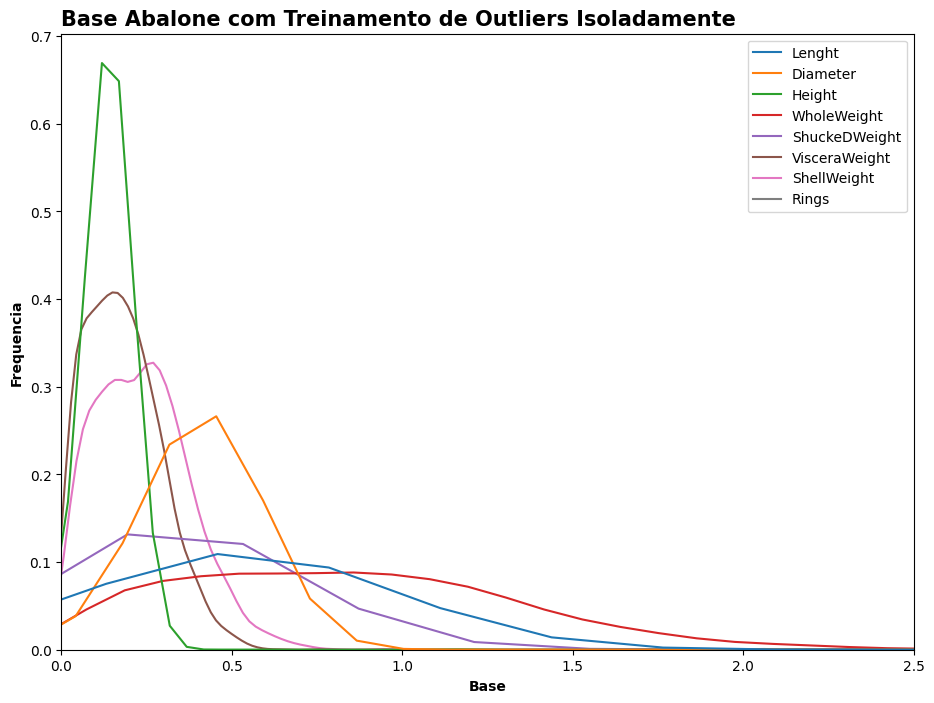

In [ ]:
# Grafico de frequencia da base com imputacao de outliers separado
plt.figure(figsize=(11,8))
sns.kdeplot(data=base_NoNa_Complete)
plt.title("Base Abalone com Treinamento de Outliers Isoladamente", fontsize=15, fontweight= "bold", loc="left")
plt.xlabel("Base",fontweight= "bold")
plt.ylabel("Frequencia",fontweight= "bold")
plt.xlim(0, 2.5)
plt.show()

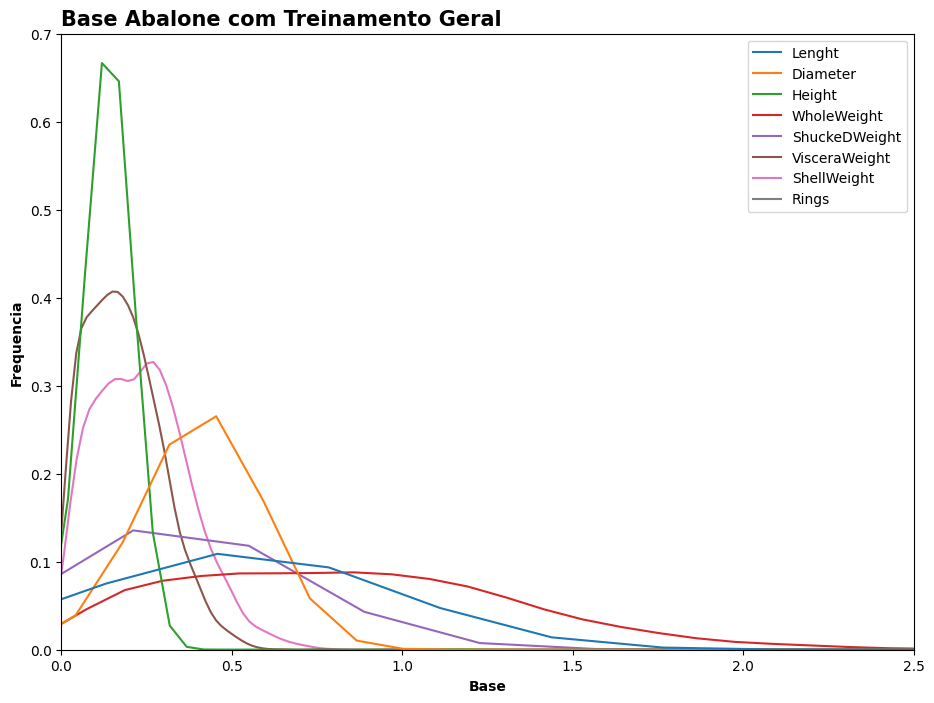

In [ ]:
# # Grafico de frequencia base com imputação conjunta dos outliers
plt.figure(figsize=(11,8))
sns.kdeplot(data=base_withOutliersComplete)
plt.title("Base Abalone com Treinamento Geral", fontsize=15, fontweight= "bold", loc="left")
plt.xlabel("Base",fontweight= "bold")
plt.ylabel("Frequencia",fontweight= "bold")
plt.xlim(0, 2.5)
plt.show()

**A partir dos 3 gráficos, podemos agora apresentar uma linha de raciocínio conclusória. Como discorremos anteriormente e, voltamos a reforçar, nosso objetivo central foi inputar os dados faltantes na Base Original através do algoritmo KNN e, descobrir em qual base de treinamento obteríamos o melhor desempenho perante a métrica alvo mostrada em tais gráficos de frequência... A métrica alvo definida foi a menor variabilidade da frequência em comparação a base original.**

**Ressaltamos ainda que, a escolha do KNN como metodologia de inputação dos dados foi pensado a partir do conhecimento prévio desse algoritmo. Sua capacidade de inputar dados através de um poderoso conjunto de regras não nos deixou questionamentos ao definir como uma ótima escolha, além do fato de que ao parecer dos resultados acima, foi conveniente.**

**Como definimos que tais resultados possam ter sido bons foi, justamente, avaliando que a variabilidade original e das duas variáveis subsequentes foi mínima. Além disso, curiosamente tivemos as duas variáveis de teste com resultados semelhantes na apresentação, o que nos leva a uma via conclusiva contrária em relação ao que estabelecemos anteriormente (que seria definir um único cenário ganhador).**

**De forma alguma consideramos, por fim, que se trata de um desperdício de esforços que tenhamos criado tal contextualização. Pelo contrário, enxergamos como sucesso, dado a oportunidade de manipulação das amostras e capacidade de raciocínio lógico a qual nos forçamos a testar com base dos cenários criados anteriormente. Isso sem contar que, como também apresentado anteriormente, tivemos o zelo de criar o teste de acurácia para encontrar mais parâmetros do qual poderíamos nos apoiar como métricas de sucesso no ato da inputação**

# **Armazenando a base de dados**

**Por conseguinte aos fatos gerados, estaremos agora salvando uma das bases treinadas. Apesar de nossa conclusão de empate, demos preferência proposital a variável da base com Outliers treinados separadamente, pensando no fator lógico de termos criado um cenário mais controlado para a execução do KNN em relação a seu semelhante que foi treinado com todos os dados 'misturados'.**

In [ ]:
base_NoNa_Complete.to_csv('abalone-tratado.csv', index=False, header=None)